In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing

In [23]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('ASTC','yahoo',start,end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-12-21,120.0,125.0,120.0,120.0,120.0,70200.0
1995-12-22,120.0,122.5,120.0,120.0,120.0,41600.0
1995-12-26,120.0,122.5,120.0,120.0,120.0,1500.0
1995-12-27,122.5,122.5,120.0,120.0,120.0,6600.0
1995-12-28,120.0,122.5,120.0,120.0,120.0,22500.0


In [24]:
def derivative(df):
    df['d1close'] = df.Close.diff()
    df['d2close'] = df.d1close.diff()
    df['d1vol'] = df.Volume.diff()
    df['d2vol'] = df.d1vol.diff()
    return df

In [27]:
data = derivative(data)
data.head()

In [31]:
# fill NA with zero (from derivatives)
data = data.fillna(0)

# Normalise and Prepozess the data like a boss^12

In [32]:
#normalise data
data_n = stock_data_preprocessing.normalise_stock_data(data)
data_n.head()

,d1close,d2close,d1vol,d2vol,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,,,,,
1995-12-21,0.0,0.0,0.0,0.0,0.728648,3.0,0.006483,1.0,1.000000,1.041667,1.0,0.000000,0.0,0.000000,0.000000,0.0
1995-12-22,0.0,0.0,-28600.0,0.0,0.728649,4.0,0.003842,1.0,1.000000,1.020833,1.0,-0.996158,0.0,0.000000,0.020833,0.0
1995-12-26,0.0,0.0,-40100.0,-11500.0,0.728653,1.0,0.000139,1.0,1.000000,1.020833,1.0,-0.999861,0.0,0.000000,0.020833,0.0
1995-12-27,0.0,0.0,5100.0,45200.0,0.728654,2.0,0.000609,1.0,1.020833,1.020833,1.0,-0.999391,0.0,0.020833,0.020833,0.0
1995-12-28,0.0,0.0,15900.0,10800.0,0.728655,3.0,0.002078,1.0,1.000000,1.020833,1.0,-0.997922,0.0,0.000000,0.020833,0.0


# 1,2,3 Plot Line!

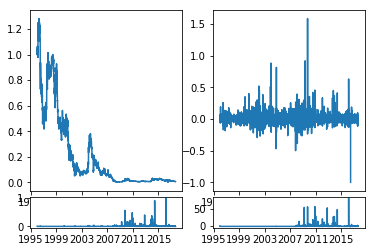

In [33]:
stock_data_preprocessing.stock_plot((data_n,))

# Pickup the Data

In [34]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [35]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4961, 16)
y_train (4961,)
x_test (500, 16)
y_test (500,)


# unroll it

In [33]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4911, 50, 12)
y_train (4911,)
x_test (450, 50, 12)
y_test (450,)


# Model Building

In [34]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [35]:
x_train.shape

(4911, 50, 12)

In [36]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[-1]),
    units =50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.03125119209289551


In [37]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=50,
    validation_split=0.05)

Train on 4665 samples, validate on 246 samples
Epoch 1/50
4665/4665 [==============================] - 15s - loss: 0.1265 - val_loss: 0.0030
Epoch 2/50
4665/4665 [==============================] - 12s - loss: 0.0082 - val_loss: 0.0012
Epoch 3/50
4665/4665 [==============================] - 12s - loss: 0.0072 - val_loss: 0.0012
Epoch 4/50
4665/4665 [==============================] - 12s - loss: 0.0069 - val_loss: 0.0011
Epoch 5/50
4665/4665 [==============================] - 12s - loss: 0.0069 - val_loss: 0.0012
Epoch 6/50
4665/4665 [==============================] - 12s - loss: 0.0065 - val_loss: 0.0012
Epoch 7/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0011
Epoch 8/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0012
Epoch 9/50
4665/4665 [==============================] - 12s - loss: 0.0064 - val_loss: 0.0012
Epoch 10/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0012
Epoch 11/50


yo


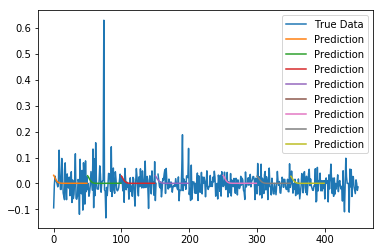

In [38]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [14]:
predictions = lstm.predict_point_by_point(model, x_test)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'lstm' is not defined